In [3]:
import numpy as np
import os

DATA_PATH = 'Anuran_Calls_(MFCCs)'

In [4]:
import pandas as pd

def load_csv(path = DATA_PATH):
    csv_path = os.path.join(path, 'Frogs_MFCCs.csv')
    return pd.read_csv(csv_path)

In [5]:
df = load_csv()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
MFCCs_ 1    7195 non-null float64
MFCCs_ 2    7195 non-null float64
MFCCs_ 3    7195 non-null float64
MFCCs_ 4    7195 non-null float64
MFCCs_ 5    7195 non-null float64
MFCCs_ 6    7195 non-null float64
MFCCs_ 7    7195 non-null float64
MFCCs_ 8    7195 non-null float64
MFCCs_ 9    7195 non-null float64
MFCCs_10    7195 non-null float64
MFCCs_11    7195 non-null float64
MFCCs_12    7195 non-null float64
MFCCs_13    7195 non-null float64
MFCCs_14    7195 non-null float64
MFCCs_15    7195 non-null float64
MFCCs_16    7195 non-null float64
MFCCs_17    7195 non-null float64
MFCCs_18    7195 non-null float64
MFCCs_19    7195 non-null float64
MFCCs_20    7195 non-null float64
MFCCs_21    7195 non-null float64
MFCCs_22    7195 non-null float64
Family      7195 non-null object
Genus       7195 non-null object
Species     7195 non-null object
RecordID    7195 non-null int64
dtypes: float6

In [7]:
# Number of instances by class
df.loc[:,'Family'].value_counts()

Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64

In [8]:
df.loc[:,'Genus'].value_counts()

Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64

In [9]:
df.loc[:,'Species'].value_counts()

AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens       472
HylaMinuta                 310
LeptodactylusFuscus        270
ScinaxRuber                148
OsteocephalusOophagus      114
Rhinellagranulosa           68
Name: Species, dtype: int64

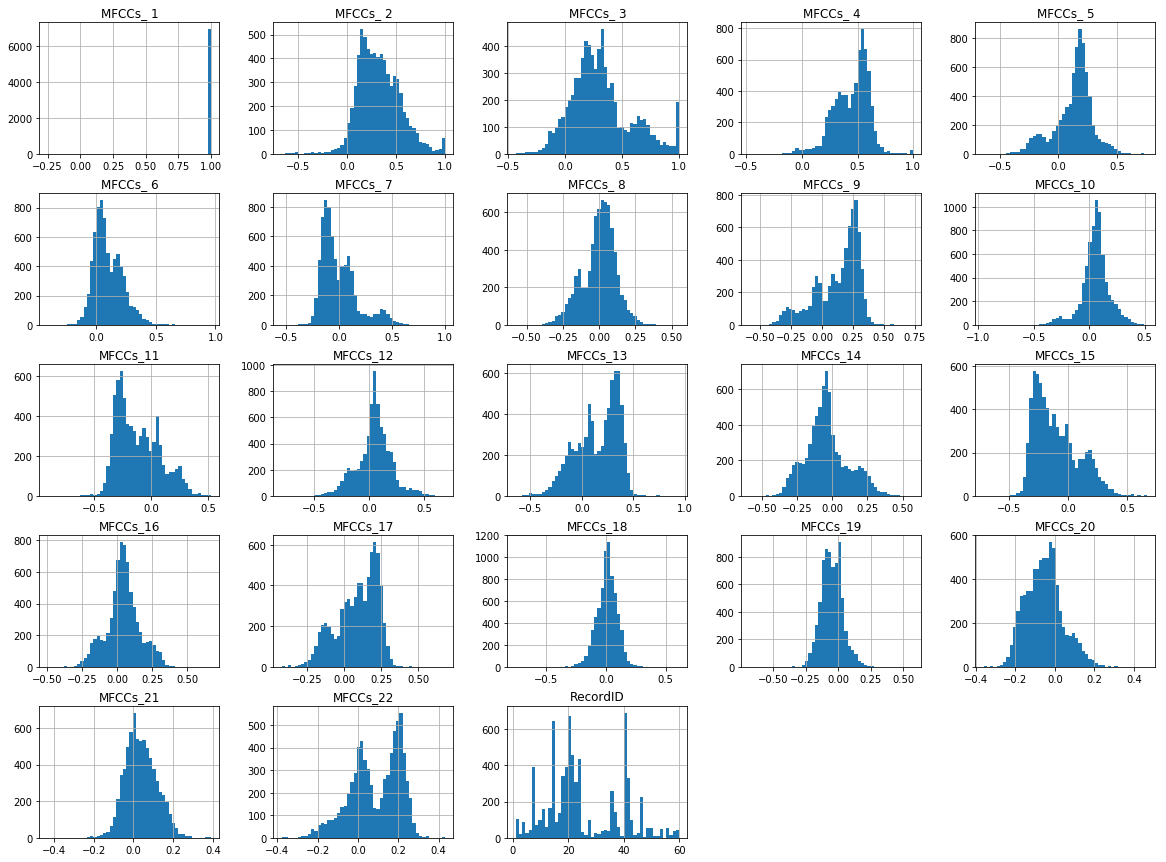

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [11]:
X, Y = df.loc[:,'MFCCs_ 1':'MFCCs_22'], df.loc[:, 'Family':'Species']

In [12]:
X.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22
count,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,...,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000
mean,0.989885,0.323584,0.311224,0.445997,0.127046,0.097939,-0.001397,-0.000370,0.128213,0.055998,...,0.150945,-0.039244,-0.101748,0.042062,0.088680,0.007755,-0.049474,-0.053244,0.037313,0.087567
std,0.069016,0.218653,0.263527,0.160328,0.162722,0.120412,0.171404,0.116302,0.179008,0.127099,...,0.206880,0.152515,0.187618,0.119915,0.138055,0.084733,0.082546,0.094181,0.079470,0.123442
min,-0.251179,-0.673025,-0.436028,-0.472676,-0.636012,-0.410417,-0.538982,-0.576506,-0.587313,-0.952266,...,-0.644116,-0.590380,-0.717156,-0.498675,-0.421480,-0.759322,-0.680745,-0.361649,-0.430812,-0.379304
25%,1.000000,0.165945,0.138445,0.336737,0.051717,0.012581,-0.125737,-0.063109,0.004648,-0.001132,...,-0.002859,-0.132980,-0.255929,-0.019549,-0.001764,-0.042122,-0.106079,-0.120971,-0.017620,0.000533
50%,1.000000,0.302184,0.274626,0.481463,0.161361,0.072079,-0.052630,0.013265,0.189317,0.063478,...,0.196921,-0.050715,-0.143259,0.041081,0.112769,0.011820,-0.052626,-0.055180,0.031274,0.105373
75%,1.000000,0.466566,0.430695,0.559861,0.222592,0.175957,0.085580,0.075108,0.265395,0.117725,...,0.324589,0.039157,0.017348,0.107046,0.201932,0.061889,0.006321,0.001342,0.089619,0.194819
max,1.000000,1.000000,1.000000,1.000000,0.752246,0.964240,1.000000,0.551762,0.738033,0.522768,...,0.945710,0.575749,0.668924,0.670700,0.681157,0.614064,0.574209,0.467831,0.389797,0.432207


In [13]:
Y.describe()

,Family,Genus,Species
count,7195,7195,7195
unique,4,8,10
top,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
freq,4420,4150,3478


In [14]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# values of species
species_data = Y.loc[:,'Species']

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(species_data)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[0 0 0 ... 9 9 9]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [53]:
from keras.models import Sequential

model = Sequential()

In [54]:
from keras.layers import Dense, Dropout

model.add(Dense(units=64, activation='relu', input_dim=22))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=10, activation='softmax')) #10 species

In [55]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [56]:
# x_train and y_train are Numpy arrays --just like in the Scikit-Learn API.
model.fit(X, onehot_encoded, epochs=200, batch_size=128)

Epoch 1/200
7195/7195 [==============================] - 1s 81us/step - loss: 2.1582 - acc: 0.3871
Epoch 2/200
7195/7195 [==============================] - 0s 34us/step - loss: 1.8345 - acc: 0.4834
Epoch 3/200
7195/7195 [==============================] - 0s 31us/step - loss: 1.5923 - acc: 0.4834
Epoch 4/200
7195/7195 [==============================] - 0s 29us/step - loss: 1.4677 - acc: 0.4834
Epoch 5/200
7195/7195 [==============================] - 0s 34us/step - loss: 1.3579 - acc: 0.4845
Epoch 6/200
7195/7195 [==============================] - 0s 32us/step - loss: 1.2523 - acc: 0.4949
Epoch 7/200
7195/7195 [==============================] - 0s 35us/step - loss: 1.1640 - acc: 0.5880
Epoch 8/200
7195/7195 [==============================] - 0s 31us/step - loss: 1.0958 - acc: 0.6799
Epoch 9/200
7195/7195 [==============================] - 0s 34us/step - loss: 1.0443 - acc: 0.6994
Epoch 10/200
7195/7195 [==============================] - 0s 39us/step - loss: 1.0045 - acc: 0.7106
Epoch 11/

7195/7195 [==============================] - 0s 33us/step - loss: 0.2315 - acc: 0.9412
Epoch 83/200
7195/7195 [==============================] - 0s 31us/step - loss: 0.2294 - acc: 0.9418
Epoch 84/200
7195/7195 [==============================] - 0s 39us/step - loss: 0.2274 - acc: 0.9420
Epoch 85/200
7195/7195 [==============================] - 0s 33us/step - loss: 0.2257 - acc: 0.9434
Epoch 86/200
7195/7195 [==============================] - 0s 40us/step - loss: 0.2237 - acc: 0.9437
Epoch 87/200
7195/7195 [==============================] - 0s 36us/step - loss: 0.2219 - acc: 0.9443
Epoch 88/200
7195/7195 [==============================] - 0s 32us/step - loss: 0.2200 - acc: 0.9448
Epoch 89/200
7195/7195 [==============================] - 0s 30us/step - loss: 0.2183 - acc: 0.9464
Epoch 90/200
7195/7195 [==============================] - ETA: 0s - loss: 0.2172 - acc: 0.947 - 0s 28us/step - loss: 0.2166 - acc: 0.9469
Epoch 91/200
7195/7195 [==============================] - 0s 34us/step - lo

7195/7195 [==============================] - 0s 33us/step - loss: 0.1527 - acc: 0.9629
Epoch 164/200
7195/7195 [==============================] - 0s 36us/step - loss: 0.1524 - acc: 0.9622
Epoch 165/200
7195/7195 [==============================] - 0s 33us/step - loss: 0.1516 - acc: 0.9622
Epoch 166/200
7195/7195 [==============================] - 0s 34us/step - loss: 0.1510 - acc: 0.9629
Epoch 167/200
7195/7195 [==============================] - 0s 37us/step - loss: 0.1505 - acc: 0.9625
Epoch 168/200
7195/7195 [==============================] - 0s 32us/step - loss: 0.1499 - acc: 0.9625
Epoch 169/200
7195/7195 [==============================] - 0s 35us/step - loss: 0.1496 - acc: 0.9622
Epoch 170/200
7195/7195 [==============================] - 0s 31us/step - loss: 0.1490 - acc: 0.9636
Epoch 171/200
7195/7195 [==============================] - 0s 32us/step - loss: 0.1486 - acc: 0.9628
Epoch 172/200
7195/7195 [==============================] - 0s 39us/step - loss: 0.1480 - acc: 0.9626
Epoc

In [58]:
#classes = model.evaluate(X, onehot_encoded, batch_size=128)
classes = model.fit(X, onehot_encoded)

Epoch 1/1
7195/7195 [==============================] - 0s 34us/step - loss: 0.1339 - acc: 0.9657


[0.5269452408722409, 0.8300208478109798]
